In [1]:
""" `imageio_ffmpeg` contains a pre-built `ffmpeg` binary, needed for mp3 decoding by `librosa`. 
    It is installed as a custom package on Kaggle. If no `ffmpeg` binary is found in 
    `/usr/local/bin` then create a softlink to the `imageio_ffmpeg` binary. 
"""
import os
if not os.path.exists("/usr/local/bin/ffmpeg"): 
    #! pip install imageio_ffmpeg 
    import imageio_ffmpeg
    os.link(imageio_ffmpeg.get_ffmpeg_exe(), "/usr/local/bin/ffmpeg")
    
""" Common imports """
import pandas as pd
import numpy as np
import librosa 
from librosa.display import specshow
from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from glob import glob
import re
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from itertools import islice

def parse_shape(shape_str):
    """Shape was saved in feature_shapes as a string. Woops.
       Convenience funtion to parse out the values. """
    a,b = re.search('\((\d+), (\d+)\)',shape_str).groups()
    return int(a), int(b)

def log_clipped(a):
    """Convenience function to clip the input to positive values then return the log.""" 
    return np.log(np.clip(a,.0000001,a.max()))

""" Datasets """
sg_dir = "../input/avian-vocalizations-spectrograms-and-mfccs/melspectrograms/features/"
sglog_dir = "../input/avian-vocalizations-melspectrograms-log-norm/melspectrograms_logscaled_normalized/features/"
mfcc_dir = "../input/avian-vocalizations-spectrograms-and-mfccs/mfccs/features/"

shapes_df = pd.read_csv("../input/avian-vocalizations-spectrograms-and-mfccs/feature_shapes.csv",
                        index_col=0 )
# Parse the length from the melspectrogram_shape field, which was inadvertantly saved as a string
train_df = pd.read_csv("../input/avian-vocalizations-partitioned-data/train_file_ids.csv",
                       index_col=0)
test_df = pd.read_csv("../input/avian-vocalizations-partitioned-data/test_file_ids.csv",
                      index_col=0)

Using TensorFlow backend.


# Machine Learning Engineer Nanodegree
## Capstone Project
Sam Hiatt
Aug 15, 2019

## I. Project Definition

### Overview

#### Background

Many social animals communicate using vocalizations that can give clues to their species as well as to their intent. The ability to automatically classify audio recordings of animal vocalizations opens up countless opportunities for sound-aware computer applications and could help accelerate studies of these animals. For example, a classifier trained to recognize the call of a specific species of bird could be used to trigger a camera recording, or automatically tag a live audio stream containing avian calls with the species of the bird that made it, producing a time-series record of the presence of this species.

[Xeno-Canto.org](https://www.xeno-canto.org/) is an online community and crowd-sourced Creative Commons database containing audio recordings of avian vocalizations from around the world, indexed by species. It presents a good opportunity for experimentation with machine learning for classification of audio signals. The [Xeno-Canto Avian Vocalizations CA/NV, USA](https://www.kaggle.com/samhiatt/xenocanto-avian-vocalizations-canv-usa) dataset was procured for the purpose of jumpstarting exploration into this space. It contains a small subset of the available data, including 30 varying-length audio samples for each of 91 different bird species common in California and Nevada, USA.

[Spectrograms](https://en.wikipedia.org/wiki/Spectrogram) (also called sonograms) map audio signals into 2-dimensional frquency-time space, and have long been used for studying animal vocalizations. [Bird Song Research: The Past 100 Years](https://courses.washington.edu/ccab/Baker%20-%20100%20yrs%20of%20birdsong%20research%20-%20BB%202001.pdf) describes how a device called the Sona-Graph™, developed by Kay Electric in 1948, began to be used by ornithologists in the early 1950's and accelerated avian bioacoustical research. The project [DeepSqueak](https://github.com/DrCoffey/DeepSqueak) at the University of Washington in Seattle uses spectrograms of ultrasonic vocalizations of mice and takes a deep learning approach to classifying their recordings. Their publication in Nature, [DeepSqueak: a deep learning-based system for detection and analysis of ultrasonic vocalizations](https://www.nature.com/articles/s41386-018-0303-6), shows how their classifier us used to study correlations between types of vocalizations and specific behaviors.

[Mel-frequency Cepstral Coefficients (MFCCs)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) also map audio signals into 2-dimensional space and are commonly used in voice recognition tasks. Inspired by the DeepSqueak's use of spectrograms as inputs to convolutional neural networks, this project uses spectrograms and MFCCs to train a classifier for avian vocalizations.

### Problem Statement

This project defines and trains a digital audio classifier to predict bird species given an audio sample of avian vocalizations. After being trained on a preprocessed dataset of labeled samples, the classifier will be able to read an mp3 file and return a single label representing the common English name of the most prevalent predicted species in the recording.

This effort focuses on just a small subset of the available xeno-canto.org data. While many additional samples are available and could be used to improve the accuracy for any particular species of interest, or more species could be added, such refinement is left for future work.

### Metrics

Performance is evaluated during model selection and training by calculating the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) on a 3-fold cross validation data split of the training data. Originally a 5-fold cross validation was planned, but after some experimentation it was determined that using 3 folds was sufficient as results were stable between splits.

Evaluation of accuracy gives equal weight to each class, considering them all equally important to identify, and is simply defined as the portion of samples correctly classified. So, for example, a model that correctly predicts the label (one out of 91 species) half of the time, would have a score of `0.50`. 

Final model performance is evaluated by first training the best model chosen during the model selection phase on the entire training dataset (without cross validation splits), and final test accuracy is evaluated by predicting labels on the designated test dataset and comparing to their true values.

## II. Analysis

### Data Exploration

Let's take a look at the dataset. We'll load the index and take a look at how the classes are distributed and verify that each species is equally represented. 

The dataset contains 91 distinct species labels.
2730 mp3s found in ../input/xenocanto-avian-vocalizations-canv-usa/xeno-canto-ca-nv/


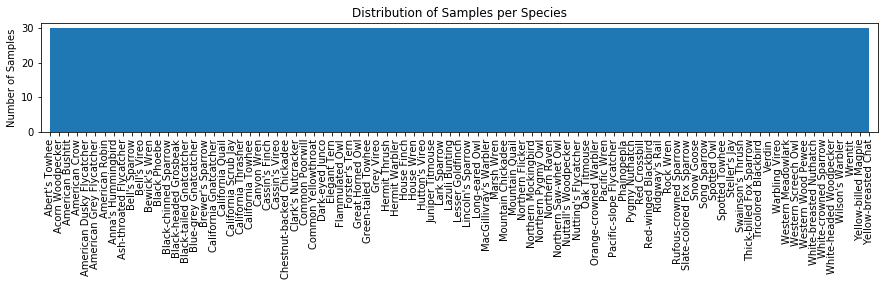

In [2]:
data_dir = '../input/xenocanto-avian-vocalizations-canv-usa/xeno-canto-ca-nv/'
df = pd.read_csv("../input/xenocanto-avian-vocalizations-canv-usa/xeno-canto_ca-nv_index.csv", 
                 index_col='file_id')
label_encoder = LabelEncoder().fit(df['english_cname'] )
n_classes = len(label_encoder.classes_)
print("The dataset contains %i distinct species labels."%n_classes)
print("%i mp3s found in %s"%(len(glob(data_dir+"*.mp3")), data_dir))

y_encoded_entire_dataset = np.array(label_encoder.transform(df['english_cname']))
plt.figure(figsize=(15,2)); plt.title("Distribution of Samples per Species")
plt.hist(y_encoded_entire_dataset, bins=91 ); plt.xlim(-1,91)
plt.ylabel("Number of Samples")
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.show();

The dataset has a balanced distribution in terms of the number of samples per species, with 30 samples for each of 91 species. 

The fact that the number of samples per class is balanced is important as each species should be represented by recordings with a variety of different environmental conditions. If, say, a single sample was chopped up and used as multiple examples for training the model would likely end up overfitting to environental factors specific to that recording, for example by picking up on the the sound of a waterfall in the background instead of listening to the birds. Having a balanced number of samples per class should help regularize environmental factors like these. 

Let's take at how the data is distributed in terms of the total duration of audio samples per class.

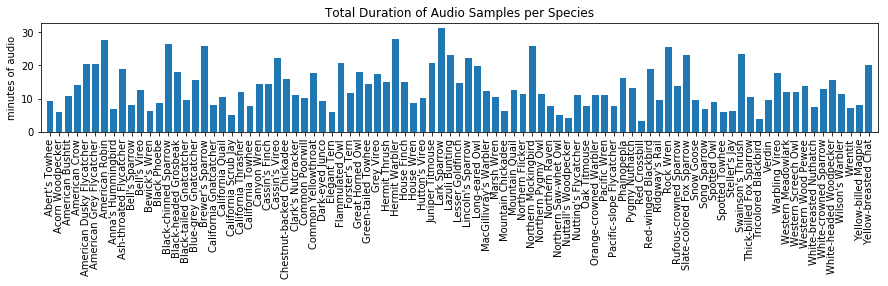

In [3]:
duration_by_class=[df.loc[df.english_cname==y,'duration_seconds'].sum()/60 
                   for y in label_encoder.classes_]
plt.figure(figsize=(15,2))
plt.title("Total Duration of Audio Samples per Species")
plt.bar(range(n_classes), duration_by_class, .75)
plt.ylabel("minutes of audio")
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.xlim(-1,91)
plt.show();

Sample lengths range from 185 seconds to 1877 seconds of audio, with a mean of 80 seconds. The data is _not_ evenly distributed in terms of the total duration of audio per class. This is due to the process used to compile the list of audio samples for each species. In particular, the 30 _shortest_ samples for each species recorded in California and Nevada were downloadedfrom xeno-canto.org, with the intention of reducing the load on the servers. This results in a dataset containing shorter samples for species that are more commonly recorded.  It will be interesting to see how this affects model performance. 

### Exploratory Visualization

Let's listen to and take a look at a few samples.  

XC119222.mp3: Abert's Towhee (Melozone aberti), contributed by: Ryan P. O'Donnell https://www.xeno-canto.org/contributor/SDXVTLDNGJ


XC79575.mp3: American Grey Flycatcher (Empidonax wrightii), contributed by: Ryan P. O'Donnell https://www.xeno-canto.org/contributor/SDXVTLDNGJ


XC79577.mp3: Ash-throated Flycatcher (Myiarchus cinerascens cinerascens), contributed by: Ryan P. O'Donnell https://www.xeno-canto.org/contributor/SDXVTLDNGJ


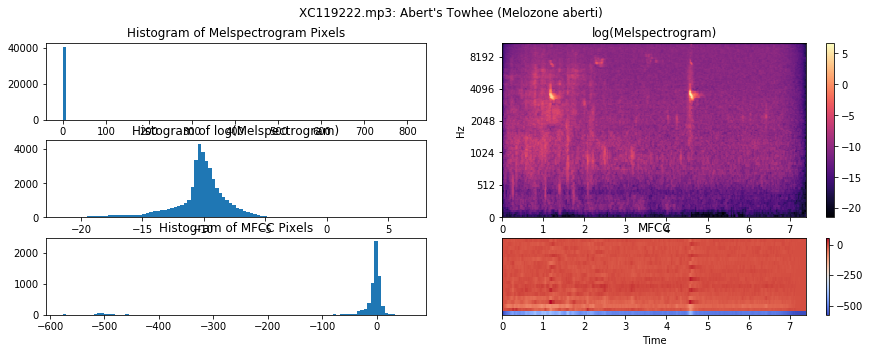

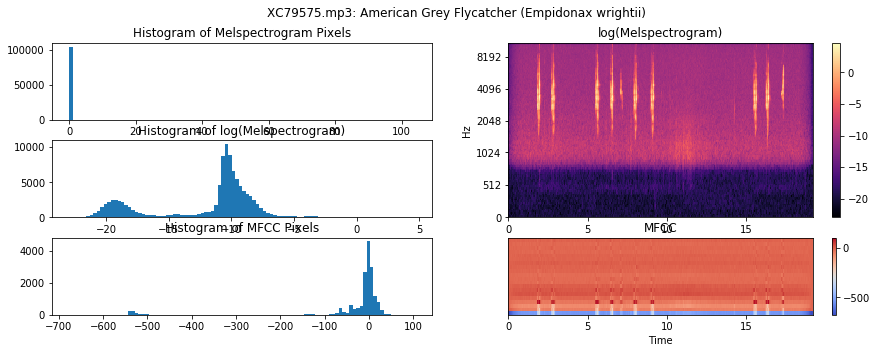

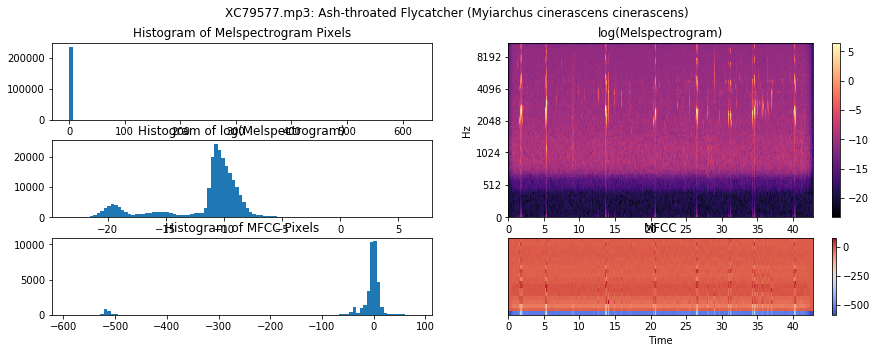

In [4]:
ryans_samples=df[df.recordist.str.contains('O\'Donnel')]
for i,sample in islice(ryans_samples.iterrows(),0,3):
# sample = df.loc[119160]
    print("%s: %s, contributed by: %s %s"%(
        sample.file_name,sample.full_name,sample.recordist,sample.recordist_url))
    data, samplerate = librosa.load(
        "../input/xenocanto-avian-vocalizations-canv-usa/xeno-canto-ca-nv/"+sample.file_name)
    Audio(data, rate = samplerate)
    hop_length = 512
    sg = librosa.feature.melspectrogram(data, sr=samplerate, hop_length=hop_length, n_fft=2048)
    mfcc = librosa.feature.mfcc(data, sr=samplerate, hop_length=hop_length, n_fft=2048)
    fig = plt.figure(figsize=(15,5)); #plt.subplots_adjust(hspace=4)
    gs = GridSpec(12,2, fig, hspace=5) # get a grid of 12 rows x 2 cols
    fig.suptitle("%s: %s"%(sample.file_name, sample.full_name))
    hist_ax1 = fig.add_subplot(gs[0:4,0])
    hist_ax2 = fig.add_subplot(gs[4:8,0])
    mfcc_hist_ax = fig.add_subplot(gs[8:,0])
    sg_ax = fig.add_subplot(gs[:8,1])
    mfcc_ax = fig.add_subplot(gs[8:,1])
    hist_ax1.hist(sg.flatten(), bins=100)
    hist_ax1.set_title("Histogram of Melspectrogram Pixels")
    hist_ax2.hist(np.log(sg.flatten()), bins=100)
    hist_ax2.set_title("Histogram of log(Melspectrogram)")
    mfcc_hist_ax.hist(mfcc.flatten(), bins=100)
    mfcc_hist_ax.set_title("Histogram of MFCC Pixels")
    specshow(np.log(sg), y_axis='mel', x_axis='time', ax=sg_ax, hop_length=hop_length)
    sg_ax.set_title("log(Melspectrogram)")
    plt.colorbar(sg_ax.get_children()[0], ax=sg_ax)
    specshow(mfcc, x_axis='time', ax=mfcc_ax, hop_length=hop_length)
    mfcc_ax.set_title("MFCC")
    plt.colorbar(mfcc_ax.get_children()[0], ax=mfcc_ax)
    display(Audio(data, rate=samplerate))
    fig.show();

After visualizing the spectrograms it is clear that their values have an exponential distribution. Scaling them with `np.log()` allows us to visualize the textures of the vocalizations. 

The MFCC values are mostly normally distributed, but it appears the bottom row has values that fall well below all the rest.  

The mean pixel and standard deviation of the spectrogram, log(melspectrogram), and mfcc arays are calculed here. 

In [5]:
sg_scaler = StandardScaler()
sg_log_scaler = StandardScaler()
ct=0
for file_id in df.index:
    shape = parse_shape(shapes_df[shapes_df.file_id==file_id]['melspectrogram_shapes'].values[0])
    sg = np.memmap('%s/XC%s_melspectrogram.dat'%(sg_dir,file_id), 
                   dtype='float32', mode='readonly', shape=shape).flatten()
    sg_scaler.partial_fit(sg.reshape(-1,1))
    sg_log_scaler = sg_log_scaler.partial_fit(log_clipped(sg).reshape(-1,1))
    ct+=shape[0]*shape[1]
print("Total number of melspectrogram pixels: %i, mean: %.5f, std. dev: %.5f"%(ct, sg_scaler.mean_, np.sqrt(sg_scaler.var_)))
print("log(melspectrogram_agg) mean: %.5f, std. dev: %.5f"%(sg_log_scaler.mean_, np.sqrt(sg_log_scaler.var_)))

Total number of melspectrogram pixels: 412313856, mean: 0.29080, std. dev: 15.13515
log(melspectrogram_agg) mean: -7.34926, std. dev: 3.56474


```Total number of melspectrogram pixels: 412313856, mean: 0.29080, std. dev: 15.13515
log(melspectrogram_agg) mean: -7.34926, std. dev: 3.56474```

In [6]:
mfcc_agg=np.array([])
mfcc_scaler = StandardScaler()
ct=0
for file_id in df.index:
    shape = parse_shape(shapes_df[shapes_df.file_id==file_id]['mfcc_shapes'].values[0])
    mfcc = np.memmap('%s/XC%s_mfcc.dat'%(mfcc_dir,file_id), 
                     dtype='float32', mode='readonly', shape=shape).flatten()
    mfcc_scaler.partial_fit(mfcc.reshape(-1,1))
    ct+=shape[0]*shape[1]
print("Total number of MFCC pixels: %i, mean: %.5f, std. dev: %.5f"%(ct,mfcc_scaler.mean_,np.sqrt(mfcc_scaler.var_)))  

Total number of MFCC pixels: 64424040, mean: -19.00330, std. dev: 86.45496


`Total number of MFCC pixels: 64424040, mean: -19.00330, std. dev: 86.45496`

### Algorithms and Techniques

The log scaled spectrograms produce visualizations with distinctive shapes and textures. The inherent interdependence of pixels that are near each other in the spectrogram make it an appropriate task for a convolutional neural network as this essentially turns this problem into a classic image classification problem. A similar model to that which was used in the [dog species classifier](https://www.kaggle.com/samhiatt/udacity-dog-project-model-selection-and-tuning) project. This model seems to perform well classifying images of dogs and using it should test the hypothesis that a CNN will perform better than the benchmark Naive Bayes model, and similarly it will be trained using gradient descent. 

The MFCC features contain information about the vocal characteristics of the frame. Adding them to the feature space can perhaps help improve predictions. Since they are correlated in time with the spectrogram, a convenience technique is applied to concatenate the two input arrays to produce a single 2-dimensional array for input to the CNN. 

Data augmentation will be employed by using a data generator that crops samples from equal-length windows of input data with a random offset. 

In order to evaluate the performance of models during experimentation, experimental models are trained and evalued on a 3-fold stratified and shuffled split to help exaluate stability and prevent model over-fitting. Final performance is evaluated by re-training the model on the entire training dataset and then evaluating against the test dataset. 




### Benchmark

A purely random predictor would be correct 1.1% of the time (1/91 classes). A [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) applied to the spectrogrampixels should perform better than random guessing and is used as a benchmark predictor. It is expected that this predictor will become sensitive to certain frequency bands that are common in a particular species' vocalizations and that this will give it some predictive power. The naieve assumption of feature independence is explected to limit this models's performance, but it should still provide a good baseline. 


## III. Methodology

### Data Preprocessing

The Kaggle kernel [Avian Vocalizations: Data Preprocessing](https://www.kaggle.com/samhiatt/avian-vocalizations-data-preprocessing) documents the data preprocessing methodology used to decode audio input files, generate spectral features, calculate statistics, and then scale and normalize data. The same steps are taken for decoding and visualizing the samples in the Exploratory Visualization section above. 

Mp3s are first decoded and Spectrograms and MFCCs are computed using librosa. The resulting arrays are stored as memory-mapped data files and saved in the Kaggle dataset [Avian Vocalizations: Spectrograms and MFCCs](https://www.kaggle.com/samhiatt/avian-vocalizations-spectrograms-and-mfccs) and used as input for further processing steps. 

Log scaling the spectrograms accounts for their exponential disctibution, and normalization zero-centers the data, making it ready for intput into a neural network. The dataset [Avian Vocalizations: Melspectrograms Log Norm](https://www.kaggle.com/samhiatt/avian-vocalizations-melspectrograms-log-norm) contains the scaled and normalized spectrograms preprocessed by calculating the `log`, subtracting the mean log scaled pixel (`mean(log(melspectrograms)) = -7.34926`, and dividing by the standard deviation (`std(log(melspectrogram)) = 3.56474`) This preprocessing is documented in the kernel [Fork of Avian Vocalizations: Data Transformation](https://www.kaggle.com/samhiatt/fork-of-avian-vocalizations-data-transformation?scriptVersionId=18761461) Use of this preprocessed data is optional as data scaling and normalization can alternatively be done in the data generation step.

A data generator modeled after [Shervine Amidi's example](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) is used to read the mem-mapped spectrograms and MFCCs and produce optionally shuffled batches of equal-length normalized samples with one-hot encoded labels. A seed is used for shuffling to allow reproducibility. One-hot encoding the labels enables categorical classification as it removes the ordinality of the encoded labels. Normalization can be done in this step if the data on disk is not already normalized. This is the case with the MFCC data due to storage space errors encountered during Kaggle kernel execution. It's fast enough to do during data generation, so for convenience MFCC normalization is done in this phase. 

The data generator is also responsible for combining the spectrogram and MFCC inputs into a single 2-dimensional array by either concatenating the MFCCs to the top of the spectrograms, or by overwriting the lower frequency bands of the spectrograms with the MFCC data. Both of these approaches for combining the arrays were evaluated for performance.

In order to select a random window of specified length from the input sample, the data generator randomly selects (again using a seed, for reproducibility) a window offset for each sample. If the input file is shorter than the crop window then the output array is padded with the dataset mean pixel value, or 0 in the case of a normalized dataset. This choice for padding the samples has implications that are discussed in the results section. 

The dataset was first partitioned with [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) reserving 1/3 of the dataset for testing, and again supplying a seed for reproducibility. This output of this split is saved in the dataset [Avian Vocalizations: Partitioned Data](https://www.kaggle.com/samhiatt/avian-vocalizations-partitioned-data) and used for training / testing in subsequent steps. 

Let's load the partitioned data take a look at some outputs from the generator.

In [7]:
X_train = list(train_df.index)
y_train = list(train_df.label)
print("Training data len:",len(X_train))
X_test = list(test_df.index)
y_test = list(test_df.label)
print("Test data len:    ",len(X_test))

Training data len: 1820
Test data len:     910


In [8]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class AudioFeatureGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size, n_frames=128, n_channels=1,
                 n_classes=10, shuffle=False, seed=37):
        'Initialization'
        self.n_frames = n_frames
        self.dim = (128, self.n_frames)
        self.batch_size = batch_size
        self.labels = {list_IDs[i]:l for i,l in enumerate(labels)}
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Update indexes, to be called after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.seed)
            self.seed = self.seed+1 # increment the seed so we get a different batch.
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X = np.empty((self.batch_size, 128+20, self.dim[1], self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int) # one-hot encoded labels

        for i, ID in enumerate(list_IDs_temp):
            sg_lognorm = np.memmap(sglog_dir+'XC%s_melspectrogram_logscaled_normalized.dat'%ID, 
                    shape=parse_shape(shapes_df[shapes_df.file_id==ID]['melspectrogram_shapes'].values[0]),  
                    dtype='float32', mode='readonly')
#             sg = np.memmap(sg_dir+'XC%s_melspectrogram.dat'%ID, 
#                     shape=parse_shape(shapes_df[shapes_df.file_id==file_id]['melspectrogram_shapes'].values[0]),  
#                     dtype='float32', mode='readonly')
            mfcc = np.memmap(mfcc_dir+'XC%s_mfcc.dat'%ID, 
                    shape=parse_shape(shapes_df[shapes_df.file_id==ID]['mfcc_shapes'].values[0]),  
                    dtype='float32', mode='readonly')
            # Normalize MFCCs
            mfcc = mfcc_scaler.transform(mfcc)
            
            # Filter out quiet frames, thanks to:
            # https://www.kaggle.com/fleanend/extract-features-with-librosa-predict-with-nb
            # Take mean amplitude M from frame with highest energy
#             m = sg[:,np.argmax(sg.mean(axis=0))].mean()
#             # Filter out all frames with energy less than 5% of M
#             mask = sg.mean(axis=0)>=m/20
#             sg = sg[:,mask]
#             sg_lognorm = sg_lognorm[:,mask]
#             mfcc = mfcc[:,mask]
            
            # Pick a random window from the sound file
            d_len = mfcc.shape[1] - self.dim[1]
            if d_len<0: # Clip is shorter than window, so pad with mean value.
                n = int(np.random.uniform(0, -d_len))
                pad_range = (n, -d_len-n) # pad with n values on the left, clip_length - n values on the right 
#                 sg_cropped = np.pad(sg, ((0,0), pad_range), 'constant', constant_values=sg.mean())
                sg_lognorm_cropped = np.pad(sg_lognorm, ((0,0), pad_range), 'constant', constant_values=0)
                mfcc_cropped = np.pad(mfcc, ((0,0), pad_range), 'constant', constant_values=0)
            else: # Clip is longer than window, so slice it up
                n = int(np.random.uniform(0, d_len))
#                 sg_cropped = sg[:, n:(n+self.dim[1])]
                sg_lognorm_cropped = sg_lognorm[:, n:(n+self.dim[1])]
                mfcc_cropped = mfcc[:, n:(n+self.dim[1])]
                
            # Stack the MFCCs and spectrograms to create a single array
            #X[i,] = np.concatenate([sg_lognorm_cropped.reshape(1,128,self.dim[1],1), 
            #                        mfcc_cropped.reshape(1,20,self.dim[1],1)], axis=1)
            X[i,] = sg_lognorm_cropped.reshape(1,128,self.dim[1],1)
            # Overwrite the bottom of X with MFCCs (we don't need the low frequency bands anyway) 
            X[i,:20] = mfcc_cropped.reshape(1,20,self.dim[1],1)
            y[i,] = to_categorical(self.labels[ID], num_classes=self.n_classes)

        return X, y

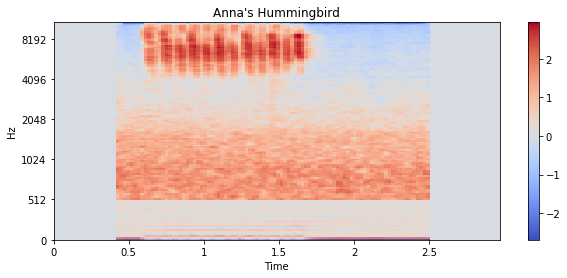

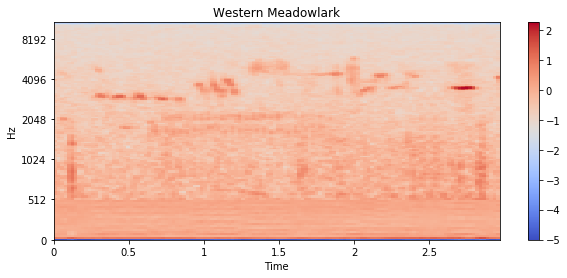

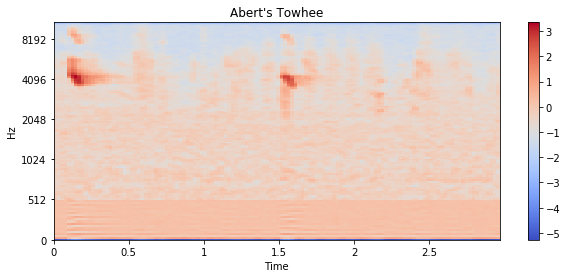

In [9]:
generator = AudioFeatureGenerator(X_train, y_train, 
            batch_size=3, shuffle=False, seed=37, n_frames=128, n_classes=n_classes)
# the 32nd batch happens to include a short sample that has been paded. Let's show it.
Xs, ys = generator[31] 
for X, y in list(zip(Xs, ys)): #(X,y for each of the 3 samples in the batch)
    plt.figure(figsize=(10,4))
    spec_ax = specshow(X.squeeze(), x_axis='time', y_axis='mel')
    plt.title(label_encoder.classes_[np.argmax(y)])
    plt.colorbar()
    plt.show()

We see that the generator is producing equal-length clips of scaled, zero-centered 2-dimensional data. Notice how the first sample has a reocrding that is shorter than the clip window length and so it has been padded with zeros. 

Let's take a look to see how data augmention is functioning. Does it produce different clips from the same sample? Let's call the generator again and compare to the clips above.

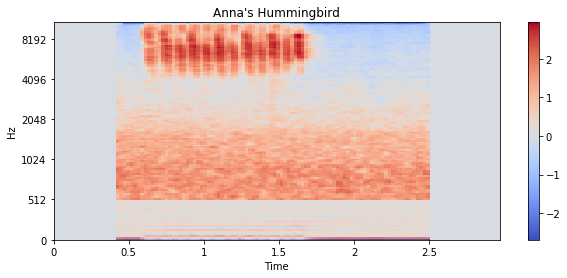

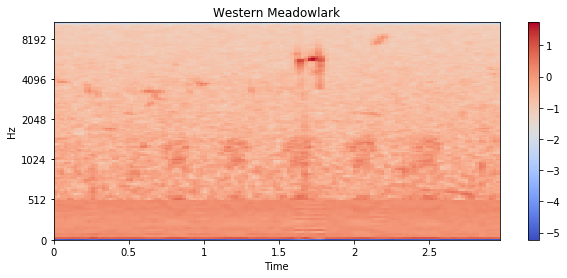

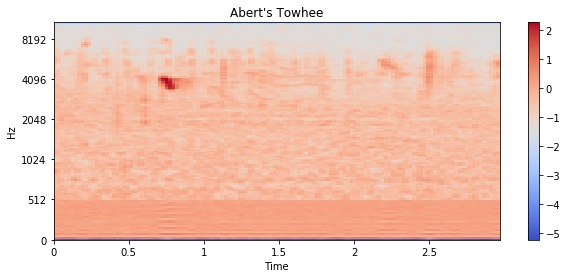

In [10]:
Xs, ys = generator[31] # Calling the generator again grabs a different random window.
for X, y in list(zip(Xs, ys)): 
    plt.figure(figsize=(10,4))
    spec_ax = specshow(X.squeeze(), x_axis='time', y_axis='mel')
    plt.title(label_encoder.classes_[np.argmax(y)])
    plt.colorbar()
    plt.show()

Notice how the samples are shifted along the time axis. So each time the generator is called a new clip is created. This technique should help the model better generalize to new data by making it sensitive to the patterns at whatever time step they occur in the sample. 

### Implementation

The model is implemented using a similar architecture to that used for the [dog species classifier](https://www.kaggle.com/samhiatt/udacity-dog-project-model-selection-and-tuning) project. This model contains three stacks of 2-d Convolution and MaxPooling layers followed by a Dropout layer with a rate of `0.2`. Convolutional layers use a ReLU activation function. The Dropout layer masks 20% of the input neurons in each layer and effectively causes the model to develop redundant neural pathways which will help the model generalize betetr to unseen data. THe output of these stacks is fed into a global average pooling layer, followed by a fully-connected layer with a softmax activation function. The position of the maximum value of this output corresponds to the predicted label.


In [11]:
model = Sequential()
dim=(128,128)
model.add(Conv2D(64,3,input_shape=(dim[0], dim[1], 1),padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(rate=.2))
model.add(Conv2D(64,3,padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(rate=.2))
model.add(Conv2D(64,3,padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(rate=.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(n_classes, activation="softmax"))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)  

A [Stratified Shuffle Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) is created from the training data, and then each training split is used to train the network using the data generator implemented above. The [keras Sequence.fit_generator](https://keras.io/models/sequential/#fit_generator) method is used to train and evaluate the model after each training epoch using instances of the generator implemented above. Evaluation is done on a single batch containing all of the validation samples. The validation data generator does not shuffle the data, however it does still augment the data by producing different cropped windows for each epoch. 

Let's try out the pipeline and train the model with cross-validation for just 3 epochs of 3 different splits.

In [12]:
n_splits = 1
n_epochs = 1
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/4, random_state=37)
scores = []
params = {'n_frames': 128,
          'n_classes': n_classes,
          'n_channels': 1}
for cv_train_index, cv_val_index in sss.split(X_train, y_train):
    training_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_train_index], 
        [y_train[i] for i in cv_train_index], 
        batch_size=64, shuffle=True, seed=37, **params)
    validation_generator = AudioFeatureGenerator(
        [X_train[i] for i in cv_val_index], 
        [y_train[i] for i in cv_val_index], 
        batch_size=len(cv_val_index), **params)
    
    partial_filename = "cnn.split%02i"%len(scores)
    checkpointer = ModelCheckpoint(filepath='weights.best.%s.hdf5'%partial_filename, verbose=1, save_best_only=True)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    learning = model.fit_generator(
                training_generator, 
                validation_data=validation_generator,
                epochs=n_epochs, 
                steps_per_epoch=np.ceil(len(cv_train_index)/training_generator.batch_size),
                validation_steps=1,
                callbacks=[checkpointer], 
#                 use_multiprocessing=True, workers=4,
                verbose=0, )
#     pd.DataFrame(learning.history).to_csv('training_history_split%i.csv'%len(scores), index_label='epoch')
#     vis_learning_curve(learning)
#     plt.savefig("learning_curve.%s.png"%partial_filename)
#     plt.show()
    acc_at_min_loss = learning.history['val_acc'][np.argmin(learning.history['val_loss'])]
    scores.append(acc_at_min_loss)
    print("Split %i: min loss: %.5f, accuracy at min loss: %.5f"%(
        len(scores), np.min(learning.history['val_loss']), acc_at_min_loss ))
print("Cross Validation Accuracy: mean(val_acc[argmin(val_loss)]): %.4f"%(np.mean(scores)))

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 4.50232, saving model to weights.best.cnn.split00.hdf5
Split 1: min loss: 4.50232, accuracy at min loss: 0.02198
Cross Validation Accuracy: mean(val_acc[argmin(val_loss)]): 0.0220


The model is able to retrieve batches from the training generator and evaluate accuracy against the validataion data. The same structure above is used to train and evaluate different versions of the model in separate kaggle kernels. The results of these experiments are reported in the next section.


### Refinement

Several different model configurations were trained and evaluated. It was observed in general that increasing the number of neurons per layer improved accuracy, as was expected.

Frame filtering was implemented following the methodolgy presented in Edoardo Ferrante's notebook [Extract features with Librosa, predict with NB](https://www.kaggle.com/fleanend/extract-features-with-librosa-predict-with-nb), however after some initial experimentation it didn't seem to improve results. It was apparent that it resulted in many more short samples requiring padding and also removed information related to tempo, distorting many of the distinguishing characteristics of the vocalizations in the spectrograms. So this approach was abandoned.

Models with different kernel and max pooling sizes, including 1-row tall convolutional kernels and MaxPooling layers were tried. The hypothesis was that the pitch of each vocalization is important and that convolution applied only to the time dimension might preserve these frequencies. This approach was tried and evaluated in the notebook [Version 16: CNN Classifier](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier/output?scriptVersionId=18872310). This model includes 64 filters for each convolutional lateyer, and uses 1x4 convolutional kernels and max pooling sizes of 1x4, 1x3, and 1x2, respectively for each layer. It is evaluated on 3 splits for 100 epochs and achieves a score of: `0.0762`. Not much better than the benchmark. 

In [Version 18](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier/output?scriptVersionId=18878731) a similar model was evaluated, except with 3x3 convolutional kernels and 2x2 max max pooling. It was trained on 3 splits to 100 epochs each and achieved a score of: `0.1238`. 

The model in [Version 17](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier/output?scriptVersionId=18872556) similarly has 60 filters per layer and uses 3x3 convolutions, but 3x3 max pooling. It achieves a score of: `0.18680`.

All of the versions above use a generator that concatenates the MFCCs to the top of the spectrograms. Another aproach was evaluated using an alternative method to combine the input arrays, simply overwriting the lowest 20 frequencies of the spectrograms with the MFCCs. The hypothesis was that the lower frequencies are unimportant for avian vocalization identification, and the results seemed to support this, as the model in [Version 20](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier?scriptVersionId=18897485) has an identical structure to that in version 17, except that it uses this alternative method of combining inputs. It achieved the top score of: `0.1927`. This model architecture and data generation method was chosen for final evaluation.

Shown below are the learning curves from the output of this training session. The minimum loss is achieved after about 80-100 epochs, and this point is indicated in the plots with a red vertical line. 

![](https://www.kaggleusercontent.com/kf/18897485/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..qjUgwDBHC6j_jcBL2Ml3Pw.JrBRZDZ9DFs_ICdzSx5A3ErbgmQKnTESxp4Om5V7jcx0U7c7zck1SLyUnY9y5cy_966QawB19jS7yA1KUX4hUXB4_l76uF4gV1f8jdjvQdVZV4cptcwN3AqB5V1JcLul4EcsAmPET4PftAi3xC5KMWB46-RgveJ1RmTpHZtpp-U.pfIsGXgKNZzCuOlQKHZdJQ/learning_curve.cnn.16.32.64.split02.png)
![](https://www.kaggleusercontent.com/kf/18897485/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..J9LeyHynwn2a1XOqeXGlFA.fPq-m2YMwbcoUB62rLVfxUx-PqJVO7w05H-LNc1ryHVePcCFeWQfoMVuVgJbzKxjy8iZegf7OcR70gpgJxp4qDpyRiejaI_KlJ8UEb7-Tc1vHO7DnfAsIMih_gWJ6rciTKNuQfkN4ujpR21se6hPR5BiCCJQHr5Au2e1gwEqbu0.N04K-JiEZQNMATxTIx_HqQ/learning_curve.cnn.16.32.64.split01.png)
![](https://www.kaggleusercontent.com/kf/18897485/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..IhEwMSfm02v3FCJRmAza7A.Jo_gjrFFg7uyYbkb2fxTMM-vFMsXaMl3SNabQYzF9UnyorfapApwqA9Y7KzRvHT5Av9R7PWONq7w_fnqffTLpNoi_TekWh5mgMbgl8UVghMPFgEq0S8X10pqsGfTBu8yWfRkcPDIFbsFcSwiBEqted1RozU7MKwUy-6MzOMbTFc.wDWfWhGH0dum-qoIrfOQ7Q/learning_curve.cnn.16.32.64.split00.png)



## IV. Results

### Model Evaluation and Validation

The model from [CNN Classifier: Version 20](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier?scriptVersionId=18897485) achieved the best score during scross-validation, and it is trained in the kernel [CNN Classifier - Train & Test](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier-train-test?scriptVersionId=18943170) on the entire training datataset (without cross-validation). The resulting weights are saved in the dataset [CNN Classifier weights](https://www.kaggle.com/samhiatt/avian-vocalizations-cnn-classifier-weights). Let's load them and test the model.

In [13]:
model.load_weights("../input/avian-vocalizations-cnn-classifier-weights/weights.best.hdf5")
params = {'n_frames': 128,
          'n_classes': n_classes,
          'n_channels': 1}
test_generator = AudioFeatureGenerator(X_test, y_test, batch_size=len(X_test), 
                                       seed=37, **params)
X_batch, y_batch = test_generator[0]
predictions = model.predict(X_batch) 
y_predicted = [np.argmax(p) for p in predictions]
y_true = [np.argmax(y) for y in y_batch]
test_score = accuracy_score(y_true, y_predicted)
print("Test accuracy score: %.5f"%test_score)

Test accuracy score: 0.25385


The final test accuracy actually exceeds the accuracy evaluated during training. This is somewhat surprising; however, considering that the model was trained on the entire training dataset, as opposed to only 1/3 of the training data the the cross-validation models saw. Having more training examples is apparently improving the model's predictive power.

To evaluate the sensitivity of the model, let's test do some more rounds of testing. Successive batches of test data will be cropped with different windows, so let's see how this stability.

In [14]:
test_scores = []
for i in range(3):
    X_batch, y_batch = test_generator[0]
    predictions = model.predict(X_batch) 
    y_predicted = [np.argmax(p) for p in predictions]
    y_true = [np.argmax(y) for y in y_batch]
    test_score = accuracy_score(y_true, y_predicted)
    print("Epoch %i test accuracy score: %.5f"%(i+1,test_score))
    test_scores.append(test_score)
print("Mean test score: %.5f, standard deviation: %.5f"%(
        np.mean(test_scores), np.std(test_scores)))

Epoch 1 test accuracy score: 0.23736
Epoch 2 test accuracy score: 0.23297
Epoch 3 test accuracy score: 0.23516
Mean test score: 0.23516, standard deviation: 0.00179


The model appears to be stable, consistently scoring around `0.24`. 

Let's download a new mp3 and try it out. Let's try a sample of an [Elegant Tern](https://www.xeno-canto.org/449570), contributed by [Richard E. Webster](https://www.xeno-canto.org/contributor/KZYUWIRZVH) which the model has not seen before.


In [15]:
from requests import get
resp = get("https://www.xeno-canto.org/449570/download")
if resp.ok:
    with open('test_sample.mp3','wb') as f:
        
        f.write(resp.content)
else:
    raise("Error downloading sample. Do you have internet access?")
data, sr = librosa.load('test_sample.mp3')
display(Audio(data, rate=sr))

The vocalization is predicted to be from a Phainopepla


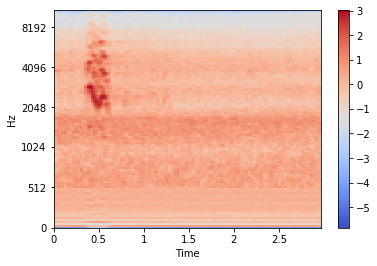

In [16]:
# Transform the data
sg = librosa.feature.melspectrogram(data, sr=sr, hop_length=512, n_fft=2048)
sg_lognorm = sg_log_scaler.transform(np.log(sg))
mfcc = librosa.feature.mfcc(data, sr=sr, hop_length=512, n_fft=2048)
mfcc_norm = mfcc_scaler.transform(mfcc)
# Grab the first 128 frames
sg_lognorm_cropped = sg_lognorm[:, :128]
mfcc_norm_cropped = mfcc_norm[:, :128]
X = sg_lognorm_cropped.copy()
X[:20] = mfcc_norm_cropped
# Visualize it
specshow(X, x_axis='time', y_axis='mel')
plt.colorbar()
# Make a prediction
predictions = model.predict([X.reshape(1,*X.shape,1)])
predicted_label = label_encoder.classes_[np.argmax(predictions)]
print("The vocalization is predicted to be from a "+predicted_label)

The Elegant Tern had the highest accuracy in testing so it should get this one right. Unfortunately, although the model did make a prediction, it incorrectly predicted the sample to be a Phainopepla. There's still room for improvement.

### Justification

Using the data generator defined above, the benchmark model is trained and tested in the cells below. 

In [17]:
training_generator = AudioFeatureGenerator(X_train, y_train, batch_size=len(X_train), 
                                           shuffle=True, seed=37, n_frames=128, 
                                           n_classes=n_classes)
scores=[]
nb = GaussianNB()
Xs, ys = training_generator[0] #  batch_size=len(X_test), so just the first batch
Xs = Xs.reshape(Xs.shape[0],Xs.shape[1]*Xs.shape[2])
ys = np.argmax(ys,axis=1)
nb.partial_fit(Xs, ys, classes=range(n_classes))
predictions = nb.predict(Xs) 
training_accuracy = accuracy_score(ys, predictions)
print("Training accuracy of benchmark model: %.5f"%training_accuracy)

Training accuracy of benchmark model: 0.18022


In [18]:
test_generator = AudioFeatureGenerator(X_test, y_test, batch_size=len(X_test),
                                       seed=37, n_frames=128, n_classes=n_classes)
Xs, ys = test_generator[0] # batch_size=len(X_test), so just the first batch
Xs = Xs.reshape(Xs.shape[0],Xs.shape[1]*Xs.shape[2])
ys = np.argmax(ys,axis=1)
predictions = nb.predict(Xs) 
test_accuracy = accuracy_score(ys, predictions)
print("Test accuracy of benchmark model: %.5f"%test_accuracy)

Test accuracy of benchmark model: 0.05275


While the benchmark model achieves a training score of `0.18022`, when evaluated aginst the test dataset its accuracy only reaches `0.05275`. The test accuracy of the CNN-based model was `0.23663`, out-performing the benchmark model by a factor of `4.5 X`. 

Let's see a breakdown of how the predictor fares for each species by plotting a confusion matrix. 

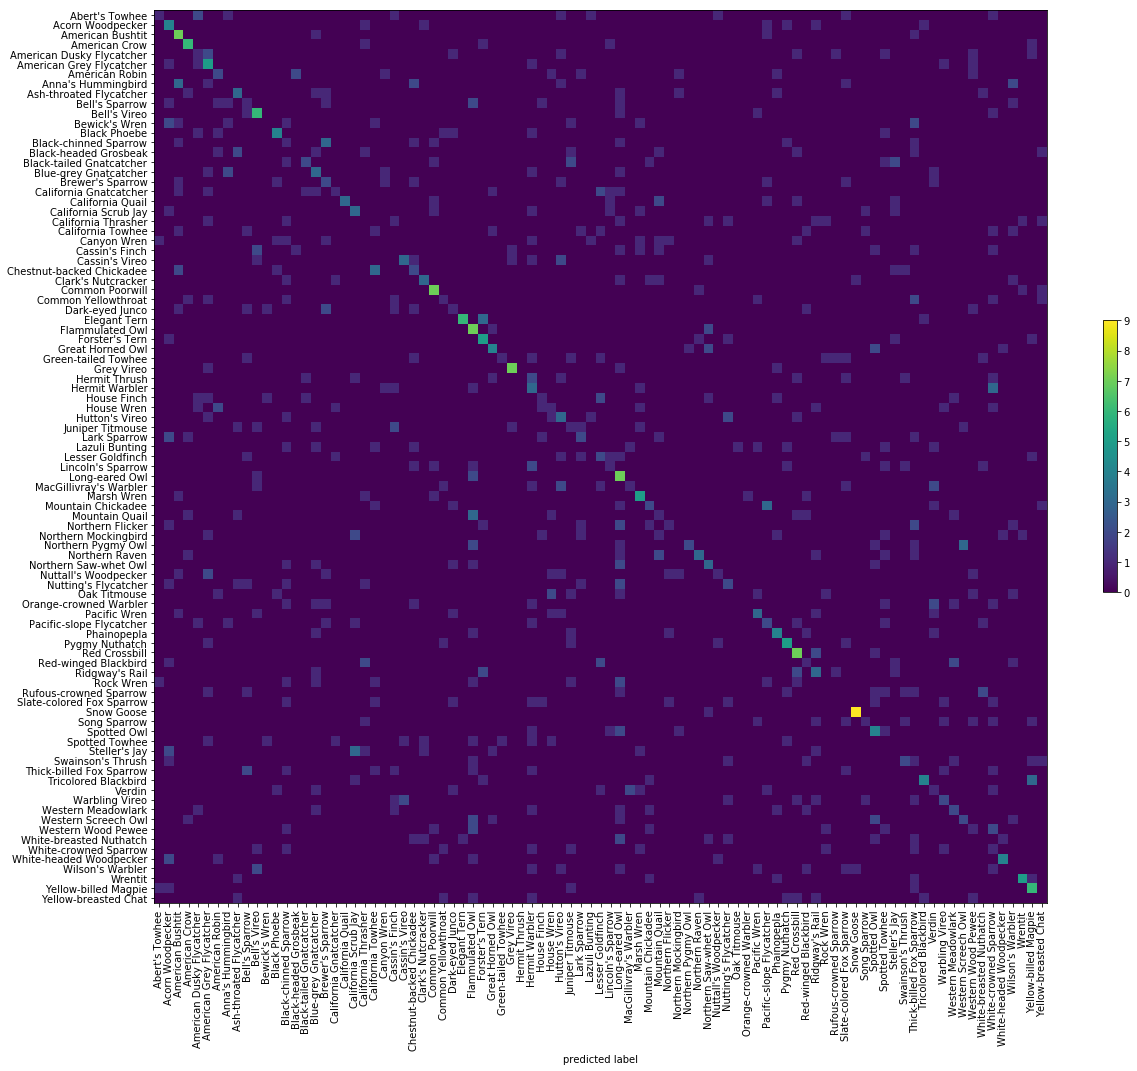

In [19]:
# Draw a confusion matrix
conf_matrix = confusion_matrix(y_true, y_predicted, labels=range(n_classes))
plt.figure(figsize=(20,20))
plt.imshow(conf_matrix)
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.xlabel("true label")
plt.yticks(range(n_classes), label_encoder.classes_)
plt.xlabel("predicted label")
plt.colorbar(shrink=.25);

Visualizing the confusion matrix shows that the accurate predictions along the diagonal are starting to line up. 

Recall that an artifact of the data collection process used to create the original dataset was that species with the most samples available actually end up having shorter samples in the dataset. It is possible that the classifier is somehow picking up on this clue. Knowing that padded clips likely came from one of these classes with shorter samples is a big clue to the classifier, one it won't have when being tested in the wild. This would be a form of data leakage. 

To see if there is a correlation between the total duration of audio per class and class accuracy, we can take a look at a scatter plot. 

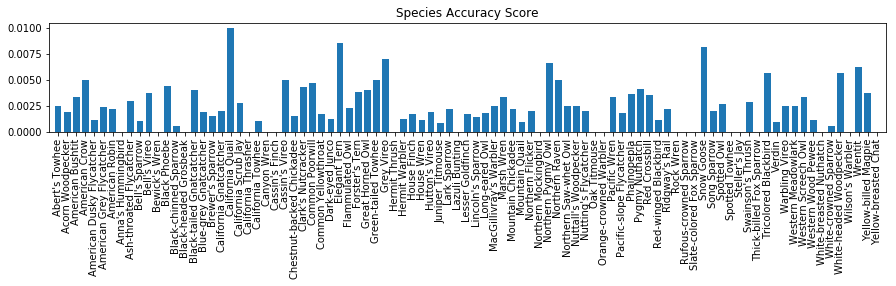

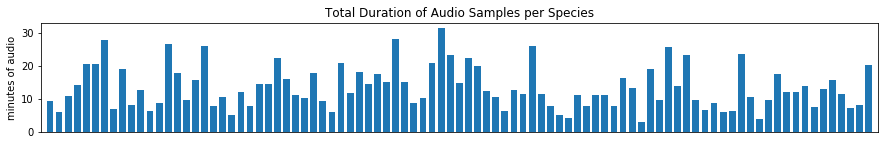

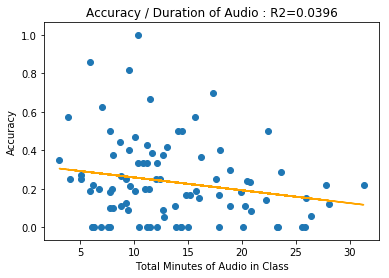

In [20]:
# Is there a correlation between total duration of audio and class accuracy?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pct_correct_by_class = np.zeros(n_classes)
counts = np.sum(conf_matrix,axis=0)
np.divide(np.array([conf_matrix[i,i] for i in range(n_classes)]), counts, 
          out=pct_correct_by_class, where=counts!=0)*100
plt.figure(figsize=(15,2))
plt.bar(range(n_classes), pct_correct_by_class/100, .75); plt.xlim(-1,91)
plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.title("Species Accuracy Score")
plt.show();

duration_by_class=[df.loc[df.english_cname==y,'duration_seconds'].sum()/60 for y in label_encoder.classes_]
plt.figure(figsize=(15,2))
plt.title("Total Duration of Audio Samples per Species")
plt.bar(range(n_classes), duration_by_class, .75); plt.xlim(-1,91)
plt.ylabel("minutes of audio")
plt.xticks([],[])
# plt.xticks(range(n_classes), label_encoder.classes_, rotation='vertical')
plt.show();

lin_model = LinearRegression()
lin_model.fit(np.array(duration_by_class).reshape(-1,1), pct_correct_by_class.reshape(-1,1))
pred = lin_model.predict(np.array(duration_by_class).reshape(-1,1))
# mse = mean_squared_error(pct_correct_by_class,pred)
r2 = r2_score(pct_correct_by_class, pred)

plt.title("Accuracy / Duration of Audio : R2=%.4f"%(r2))
plt.scatter(np.array(duration_by_class),pct_correct_by_class)
plt.plot(duration_by_class, pred, 'orange')
plt.xlabel('Total Minutes of Audio in Class')
plt.ylabel('Accuracy');

It is evident that there is a negative correlation between the total duration of audio samples and the species class accuracy. The species with shorter samples in the collection end up with greater test accuracy. The `Elegant Tern` species appears to be an outlier. It's scoring 100%. It is also a species with one of the lowest counts for total duration of audio. This is further evidence of data leakage that should be fixed.


## V. Conclusion

### Free-Form Visualization
See the Justification section for free-form visualization.

### Reflection

A convolutional neural network was trained to predict bird species heard in input audio using audio samples collected from xeno-canto.org. The samples were transformed into spectrograms and MFCCs and fed into a data generator that creates batches of equal length samples clipped from random windows of input data. Several classifiers and network configurations were evaluated using 3-fold cross validation. The best performing classifier, as measured by calculating overall prediction accuracy, was selected and trained on the entire training dataset. Final classifier performance was evaluated against the test dataset. 

The naive assumption of feature independence inherent in the benchmark Naive Bayes classifier prevents it from learning the distinguishing patterns present in the spectrograms. The translational invariance of the CNN allows it learn from these patterns even when they appear in different regions of the input data. This is in line with expected results, and in the end a CNN-based classifier was found to achieve a roughly 3X increase in accuracy over the benchmark Naieve Bayes model. 

Initial results are encouraging, but they also uncovered some issues with the dataset collection process and the methodology used by the data generator to standardize input sample lengths. 


### Improvement

Several improvements could be made to increase the accuracy of this classifier. The model architecture could be refined, experimenting with different convolution kernel and pooling sizes or by increasing the network depth and increasing memory requirements. Rigorous hyperparameter tuning could further improve accuracy. 

Transfer learning could be employed. An initial attempt was made in the kernel [Avian Vocalizations: Transfer Learning](https://www.kaggle.com/samhiatt/avian-vocalizations-transfer-learning?scriptVersionId=18845751), but found little success, likely because the spectrograms don't resemble any of the classes in the pre-trained network.

However, It is anticipated that the best gains would result from addressing the data leakage issue presented by zero-padding missing values in short samples, identified in the reflections above. Modifying the generator to simply loop short clips to fill the window would be simple technique that could address this. Additionally, balancing the training dataset during the data collection process by setting an appropriate lower limit for each audio clip duration would circumvent the need for padding.  

Additionally, improving the data generator methods with appropriate frame filtering to ensure that each cropped sample contains an identifiable vocalization would likely improve predictor performance. Any frame filtering should ensure that any rhythmic features of vocalizations are not distorted, perhaps by setting a buffer around any retained frame. Exploration into more robust audio filtering and window selection methods would likely be rewarded with additional accuray gains.

The project DeepSqueak addresses this by using a recurrent convolutional neural network (FasterR-CNN) with object region proposals that identify the locations of the vocalizations in the spectrograms. The xeno-canto.org training data does not have object regions labeled and so it can not be readily used in the same way. However, an effort could be made to create such a training dataset with expert input helping to define the regions containing vocalizations. 

More experimentation could be done with the MFCCs. They could be used independently as inputs and analyzed for their predictive power, and they could be combined with the spectrograms in a lower layer of the network. The decision to stack them onto the spectrograms was made out of convenience as it was compatible with the model from the dog breed classifier project.


## References

*  Baker, Myron C. (2001). [Bird Song Research: The Past 100 Years](https://courses.washington.edu/ccab/Baker%20-%20100%20yrs%20of%20birdsong%20research%20-%20BB%202001.pdf)
* Kevin R. Coffey, Russell G. Marx & John F. Neumaier (2019) [DeepSqueak: a deep learning-based system for detection and analysis of ultrasonic vocalizations](https://doi.org/10.1038/s41598-017-05982-x) Neuropsychopharmacology vol 44, pp 859–868.
* [Xeno Canto](https://www.xeno-canto.org), founded by Bob Planqué and Willem-Pier Vellinga.
